import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, filters, measure
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
path_imdb = '/home/skong2/restore/dataset/NYUDv2-modelZipper/imdb_nyud2_complete.mat'
imdb = scipy.io.loadmat(path_imdb)
imdb = imdb['imdb']

imdb = imdb[0][0][0][0][0]  # len(.) = 10
classMapping = imdb[1][0]
colormap4class = imdb[8]

classMapping = np.asarray([0] + list(classMapping))

In [3]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step002_det_P002_segDistTransform_v1' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'
print(device)

freqShow = 20
weight_reg = 2.0
weight_background = 0.1

#model parameters
batch_size = 12
newSize = [512, 512]
total_epoch_num = 500  # total number of epoch in training
base_lr = 0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')



result_save_to_folder = './result' # experiment directory, used for reading the init model
result_save_to_folder = os.path.join(result_save_to_folder, project_name) # where to save the log file and trained models.
if not os.path.exists(result_save_to_folder): 
    os.makedirs(result_save_to_folder)

cuda:1


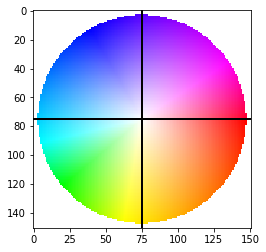

In [4]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
plt.imshow(objDemoShowFlow.FlowColorChart)
#plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)
#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [5]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'
with open('dbinfo.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)    
#dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=set_name=='train', 
                         num_workers=4) # num_work can be set to batch_size

In [6]:
################## init model ###################
path_to_save_paramOnly = path.join('./exp', project_name, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=True)

curmodel.load_state_dict(torch.load(path_to_save_paramOnly))
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

using pretrained model
False


In [7]:
iterCount, sampleCount = 0, 0
phase = 'test'
for sample in dataloaders: 
    image, grndSeg, grndDistTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize = sample
    #image, grndSeg, grndDistTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius = sample
    image = image.to(device)
    grndSeg = grndSeg.to(device) 
    grndDistTransform = grndDistTransform.to(device)
    mask_overlap = mask_overlap.to(device)
    
    iterCount += 1
    sampleCount += grndSeg.size(0)   
    
    outputs = curmodel(image)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]
    
    if iterCount == 1:
        break

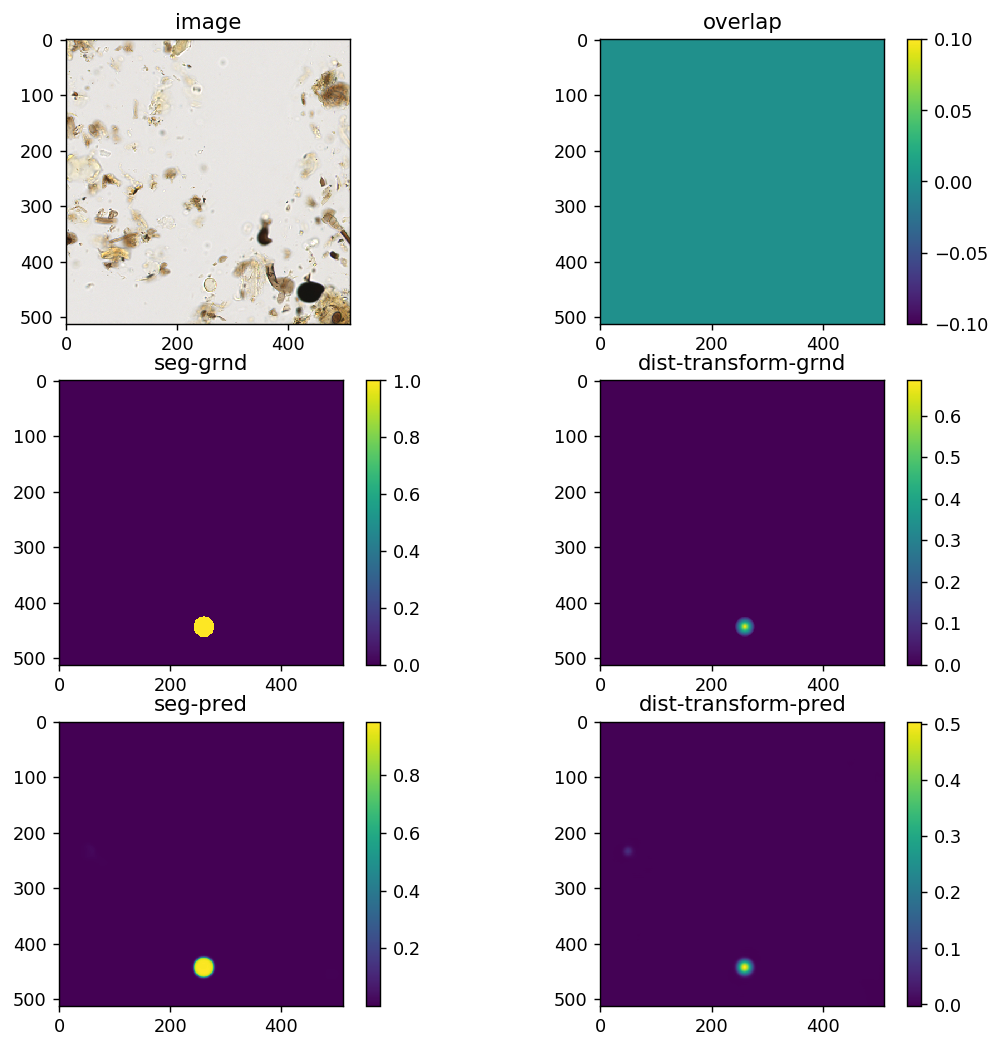

In [8]:
idx = 0

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_overlap[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = grndSeg[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg-grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = grndDistTransform[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
plt.colorbar()



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = predSeg[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg-pred')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = predDistTransform[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-pred')
plt.colorbar()


# visualize and evaluation

In [9]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    return mask

In [10]:
predBinaryMask = predSeg[idx].squeeze().cpu().detach().numpy() > 0.5
predBinaryMask = predBinaryMask.astype(np.float32)

voting4center = predDistTransform[idx].squeeze().cpu().detach().numpy()
voting4center[voting4center<0.1] = 0

In [11]:
#pred_distanceTransform = ndimage.distance_transform_edt(predBinaryMask)
pred_distanceTransform = predDistTransform[idx].squeeze().cpu().detach().numpy()
coord_peaks = feature.peak_local_max(voting4center, min_distance=5)
print(coord_peaks)

[[442 259]]


In [12]:
centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    #centerMask[y, x] = 1
    centerMask[y-10:y+10, x-10:x+10] = 1
    predRadiusList += [voting4center[y,x] *100*512/1000 * 512/1000] # /100.0/self.resizeFactor
    detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)

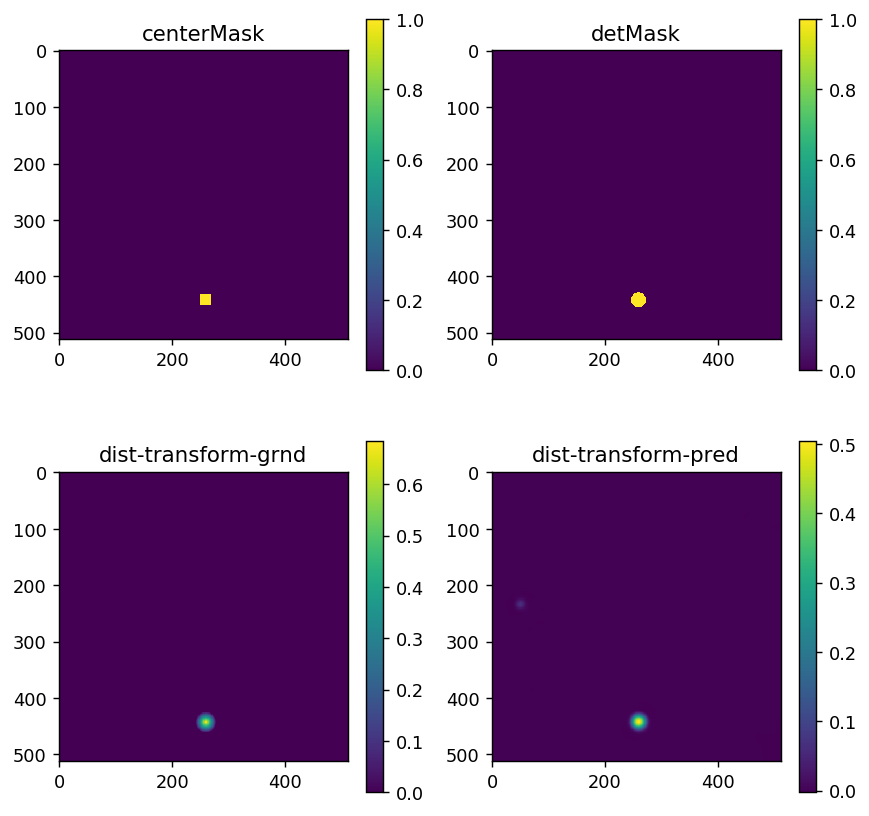

In [13]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8, 8), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(centerMask)
plt.title('centerMask')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(detMask)
plt.title('detMask')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = grndDistTransform[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(pred_distanceTransform)
plt.title('dist-transform-pred')
plt.colorbar()

# evaluation

In [53]:
iterCount, sampleCount = 0, 0
phase = 'test'
IoUList = []
for sample in dataloaders:
    #print(iterCount)
    
    image, grndSeg, grndDistTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize = sample
    
    #print('A', iterCount)
    
    image = image.to(device)
    grndSeg = grndSeg.to(device) 
    mask_voteX = mask_voteX.to(device)
    mask_voteY = mask_voteY.to(device)
    mask_overlap = mask_overlap.to(device)
    
    #print('B', iterCount)
    
    iterCount += 1
    sampleCount += grndSeg.size(0)   
    if iterCount%5==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))
    
    
    outputs = curmodel(image)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]
    
    
    image_toSave = F.interpolate(image,size=(1000,1000), mode='bilinear', align_corners=True)
    image_toSave = image_toSave[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
    image_toSave = (image_toSave+1)/2*255
    
    grndDistTransform_Resize = F.interpolate(grndDistTransform,size=(1000,1000), mode='bilinear', align_corners=True)
    grndDistTransform_Resize = grndDistTransform_Resize.squeeze().cpu().detach().numpy().astype(np.float32)
    grndDistTransform_toSave = grndDistTransform_Resize / grndDistTransform_Resize.max() * 255.0
    
    predDistTransform_Resize = F.interpolate(predDistTransform,size=(1000,1000), mode='bilinear', align_corners=True)
    predDistTransform_Resize = predDistTransform_Resize.squeeze().cpu().detach().numpy().astype(np.float32)
    predDistTransform_toSave = predDistTransform_Resize / predDistTransform_Resize.max() * 255.0
    
    predInstMask_toSave = predDistTransform_toSave*0
    grndInstMask_toSave = grndDistTransform_toSave*0
    
    #print('C', iterCount)
    
    #######################################################
    ##       ground-truth: labelOrgSize, mask_peaksOrgSize
    #######################################################
    tmpGrndList = []
    mask_peaksOrgSize = mask_peaksOrgSize.squeeze().detach().cpu().numpy()
    mask_radiusOrgSize = mask_radiusOrgSize.squeeze().detach().cpu().numpy()
    coord_peaks_OrgSize = feature.peak_local_max(mask_peaksOrgSize, min_distance=5)
    #print('D', coord_peaks_OrgSize.shape[0])
    # mask_radiusOrgSize
    for i in range(coord_peaks_OrgSize.shape[0]):
        y, x = coord_peaks_OrgSize[i]
        r = mask_radiusOrgSize[y, x]
        tmpMask = np.zeros((mask_radiusOrgSize.shape[0], mask_radiusOrgSize.shape[1]), dtype=np.float32)
        tmpMask = create_circular_mask(tmpMask, [y, x], r, value=1)
        tmpGrndList += [tmpMask.copy()]
        grndInstMask_toSave = create_circular_mask(grndInstMask_toSave, [y, x], r, value=i+1)
    
    #print('E', len(tmpGrndList))
    
    ##############################################
    ##          prediction: 
    ##############################################
    tmpPredList = []    
    idx = 0
    predBinaryMask = predSeg > 0.5   
    predBinaryMask = predBinaryMask.type(torch.float)    
    
    predBinaryMask_Resize = F.interpolate(predBinaryMask,size=(mask_peaksOrgSize.shape[0],mask_peaksOrgSize.shape[1]), mode='nearest')
    predBinaryMask_Resize = predBinaryMask_Resize.squeeze().cpu().detach().numpy().astype(np.float32)
      
    AAA = measure.label(predBinaryMask_Resize, background=0)
    for jjj in range(1, AAA.max()):
        aaa = AAA==jjj
        if aaa.astype(np.float32).sum()<100:
            predBinaryMask_Resize[aaa] = 0
            
    pred_distanceTransform_Resize = ndimage.distance_transform_edt(predBinaryMask_Resize)  
            
            
    #AAA = pred_distanceTransform_Resize # + predDistTransform_Resize
    coord_peaks_Resize = feature.peak_local_max(pred_distanceTransform_Resize, min_distance=10, exclude_border=False)
    
    centerMask = pred_distanceTransform_Resize*0
    detMask = pred_distanceTransform_Resize*0
    predRadiusList = []
    tmpPredList = []
    instIdx=1
    for i in range(coord_peaks_Resize.shape[0]):
        y, x = coord_peaks_Resize[i]
        r = pred_distanceTransform_Resize[y,x]
        tmpMask = np.zeros((predBinaryMask_Resize.shape[0], predBinaryMask_Resize.shape[1]), dtype=np.float32)
        tmpMask = create_circular_mask(tmpMask, [y, x], r, value=1)
        tmpPredList += [tmpMask.copy()]
        if r>20:
            predInstMask_toSave = create_circular_mask(predInstMask_toSave, [y, x], r, value=instIdx)
            instIdx+=1
    
    
    seg40class = grndInstMask_toSave.astype(np.float32)
    #seg40class = classMapping[seg40class.astype(np.uint16)]
    segColorShow = np.reshape(seg40class, (-1,))
    segColorShow = segColorShow.astype(np.uint16)
    segColorShow = colormap4class[segColorShow, :]
    segColorShow = np.reshape(segColorShow, (seg40class.shape[0], seg40class.shape[1], 3))
    grndInstColorMask_toSave = segColorShow * 255

    
    seg40class = predInstMask_toSave.astype(np.float32)
    #seg40class = classMapping[seg40class.astype(np.uint16)]
    segColorShow = np.reshape(seg40class, (-1,))
    segColorShow = segColorShow.astype(np.uint16)
    segColorShow = colormap4class[segColorShow, :]
    segColorShow = np.reshape(segColorShow, (seg40class.shape[0], seg40class.shape[1], 3))
    predInstColorMask_toSave = segColorShow * 255
    
    filename = path.join(result_save_to_folder, '{:04d}_image.png'.format(iterCount))
    Image.fromarray(image_toSave.astype(np.uint8)).save(filename)
    #misc.imsave(filename, image_toSave)
    filename = path.join(result_save_to_folder, '{:04d}_predDistanceTransform.png'.format(iterCount))
    Image.fromarray(predDistTransform_toSave.astype(np.uint8)).save(filename)
    #misc.imsave(filename, predFlowVisShow_toSave)
    filename = path.join(result_save_to_folder, '{:04d}_grndDistanceTransform.png'.format(iterCount))
    Image.fromarray(grndDistTransform_toSave.astype(np.uint8)).save(filename)
    #misc.imsave(filename, grndFlowVisShow_toSave)
    filename = path.join(result_save_to_folder, '{:04d}_predInstColorMask.png'.format(iterCount))
    Image.fromarray(predInstColorMask_toSave.astype(np.uint8)).save(filename)
    #misc.imsave(filename, predInstColorMask_toSave)
    filename = path.join(result_save_to_folder, '{:04d}_grndInstColorMask.png'.format(iterCount))
    Image.fromarray(grndInstColorMask_toSave.astype(np.uint8)).save(filename)
    #misc.imsave(filename, grndInstColorMask_toSave)
    
    
    
    if iterCount==50:
        break

5/1218
10/1218
15/1218
20/1218
25/1218
30/1218
35/1218
40/1218
45/1218
50/1218


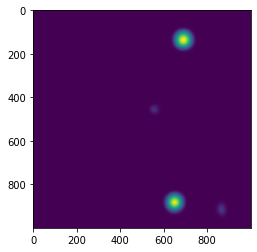

In [54]:
plt.imshow(predDistTransform_toSave)

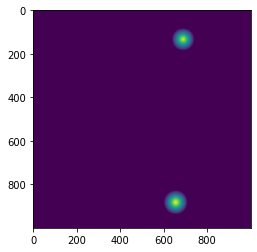

In [55]:
plt.imshow(grndDistTransform_toSave)

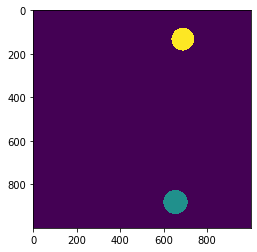

In [56]:
plt.imshow(grndInstMask_toSave)

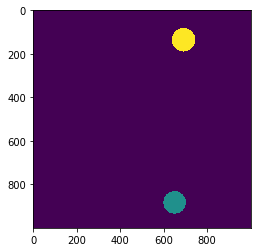

In [57]:
plt.imshow(predInstMask_toSave)



Leaving Blank
-----

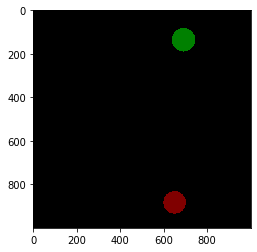

In [58]:
seg40class = predInstMask_toSave.astype(np.float32)
#print(seg40class.max(), seg40class.min())
#seg40class = classMapping[seg40class.astype(np.uint16)]
segColorShow = np.reshape(seg40class, (-1,))
segColorShow = segColorShow.astype(np.uint16)
segColorShow = colormap4class[segColorShow, :]
segColorShow = np.reshape(segColorShow, (seg40class.shape[0], seg40class.shape[1], 3))
predInstColorMask_toSave = segColorShow
plt.imshow(predInstColorMask_toSave)

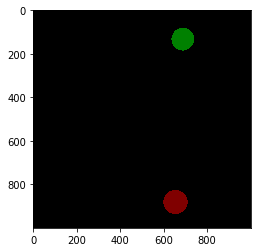

In [59]:
seg40class = grndInstMask_toSave.astype(np.float32)
#print(seg40class.max(), seg40class.min())
#seg40class = classMapping[seg40class.astype(np.uint16)]
segColorShow = np.reshape(seg40class, (-1,))
segColorShow = segColorShow.astype(np.uint16)
segColorShow = colormap4class[segColorShow, :]
segColorShow = np.reshape(segColorShow, (seg40class.shape[0], seg40class.shape[1], 3))
predInstColorMask_toSave = segColorShow
plt.imshow(predInstColorMask_toSave)